In [ ]:
import os 
import utils_plots as ut

In [2]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')
# Set basin array and basin names array
# basin_names = ['North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
# basins = ['NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
basin_names = ['North East Pacific', 'North Atlantic', 'South Indian']
basins = ['NEP', 'NA', 'SI']
# Set neural network as final model for comparison
FINAL_MODEL = 'mlp'

# Final model violin plots

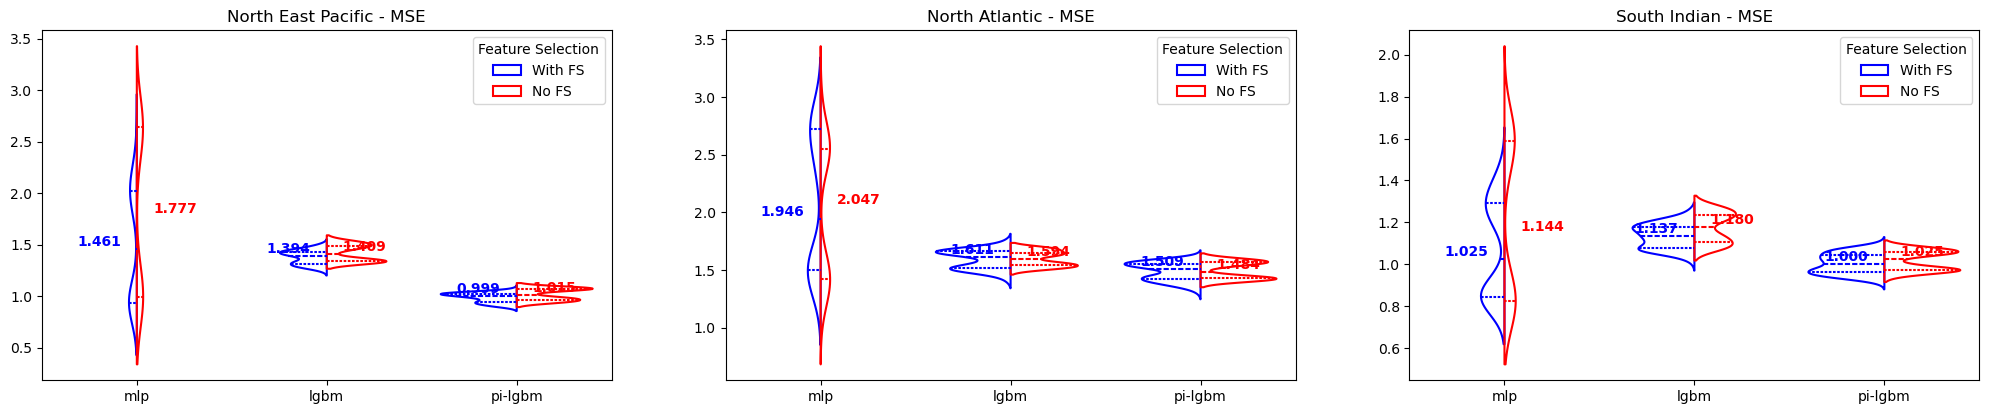

In [ ]:
fmod_violin_fig = ut.final_models_violins('MSE', results_dir, basins, basin_names, 'all', 'all')

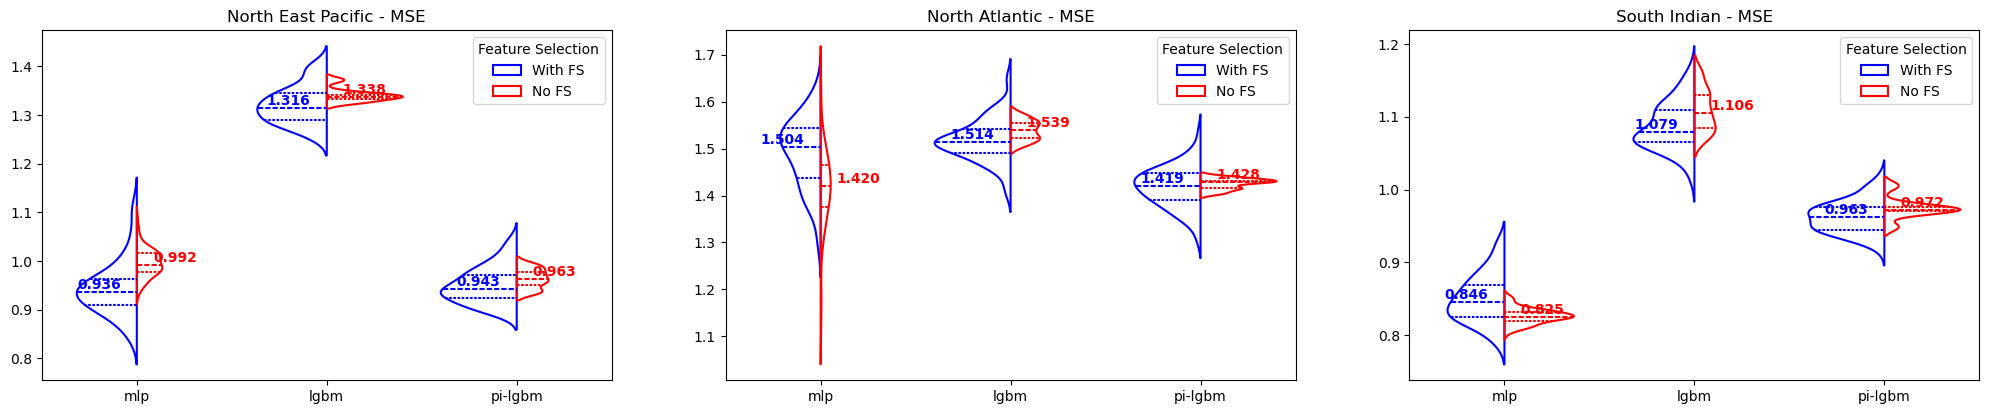

In [ ]:
fmod_violin_fig = ut.final_models_violins('MSE', results_dir, basins, basin_names, 'original', 'all')

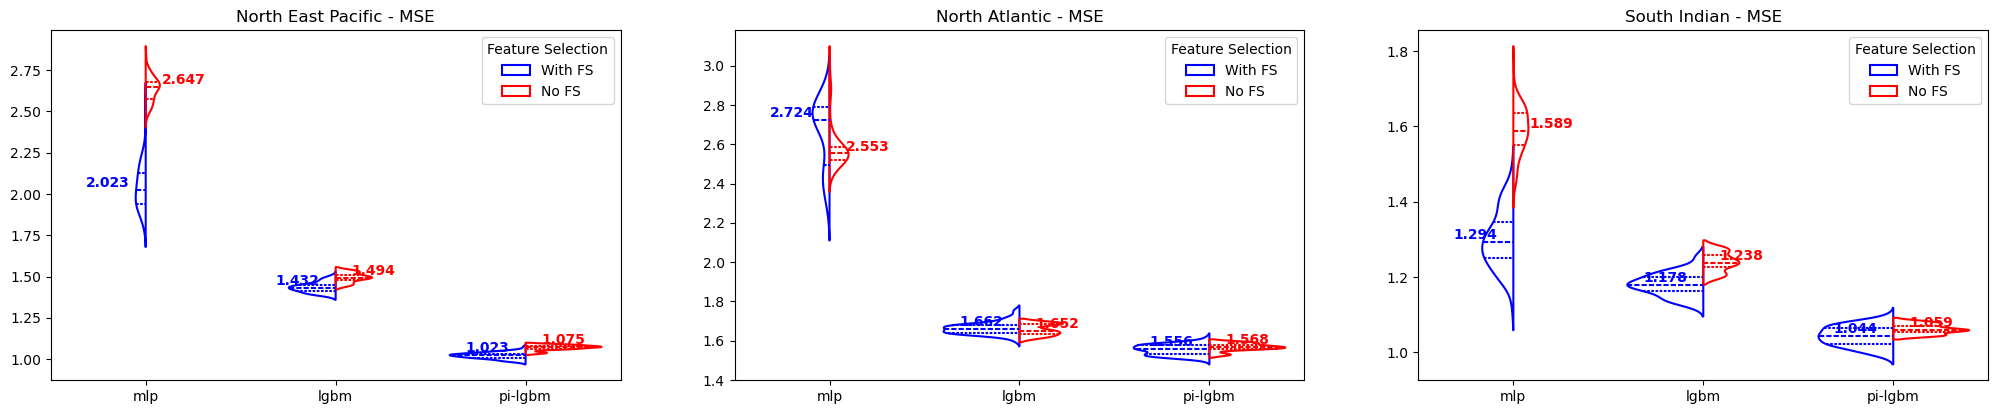

In [ ]:
fmod_violin_fig = ut.final_models_violins('MSE', results_dir, basins, basin_names, 'deseason', 'all')

In [ ]:
fmod_violin_fig = ut.final_models_violins('MSE', results_dir, basins, basin_names, 'detrend', 'all')

# Feature selection model violin plots

In [ ]:
fs_models_fig = ut.fs_models_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'all', show_noFS=True)

In [ ]:
fs_models_fig = ut.fs_models_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'original', show_noFS=True)

In [ ]:
fs_models_fig = ut.fs_models_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'deseason', show_noFS=True)

In [ ]:
fs_models_fig = ut.fs_models_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'detrend', show_noFS=True)

# Predictors type violin plots

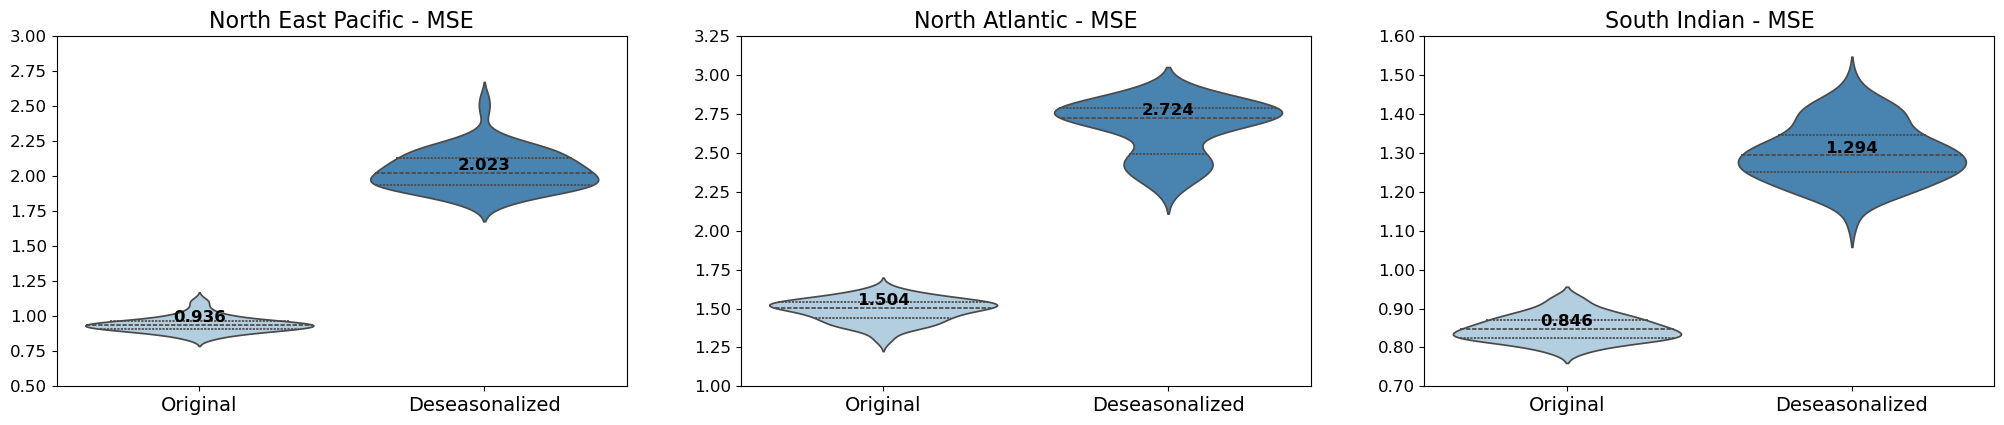

In [ ]:
pred_type_fig = ut.predictors_type_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'all')

In [ ]:
pred_type_fig = ut.predictors_type_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'linreg')

In [ ]:
pred_type_fig = ut.predictors_type_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'lgbm')

# Number of clusters violin plots

In [ ]:
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'original', 'linreg')
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'original', 'lgbm')
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'deseason', 'linreg')
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'deseason', 'lgbm')
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'detrend', 'linreg')
ncl_fig = ut.n_clusters_violins('MSE', FINAL_MODEL, results_dir, basins, basin_names, 'detrend', 'lgbm')

# Run configuration for each sub-basin

In [ ]:
run_config_dict = {
    # 'sub-basin': [predictors_type, fs_model, n_clusters]
    'NEP': ['original', 'linreg', 8],
    # 'NWP': ['original', 'linreg', 8],
    'NA': ['original', 'linreg', 8],
    # 'NI': ['original', 'linreg', 8],
    'SI': ['original', 'linreg', 8],
    # 'SP': ['original', 'linreg', 8],
}

# Heatmap to compare variable selection across the different fs models

In [ ]:
for basin in basins:
    basin_name = basin_names[basins.index(basin)]
    predictors_type, fs_model, n_clusters = run_config_dict[basin]
    ut.heatmap_var_selection_fs_models(results_dir, fs_dir, basin, basin_name, n_clusters, predictors_type)

# Heatmap to compare variable selection across 5 different tiers of model performances

In [8]:
1 / 19.18627929342034

0.05212057974903637